In [1]:
#Importing necessary libraries

import numpy as np
import pandas as pd

import time, warnings
import datetime as dt

from sklearn.cluster import KMeans

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import squarify

warnings.filterwarnings("ignore")

In [2]:
#Reading data from CSV in ISO format

data = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [3]:
#Checking the head of dataframe to see the headers and data 

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Let's do some EDA..

In [4]:
#Summary of data/overall numbers

print("Shape of the dataset: ", data.shape)
print("\nColumns present: ", list(data.columns))
print("\nNo. of invoices: ", data['InvoiceNo'].nunique())
print("\nNo. of Products: ", data['Description'].nunique())
print("\nMin. & Max. Invoice date: ", min(data['InvoiceDate']), ' & ', max(data['InvoiceDate']))
print("\nMin. & Max. Qty: ", min(data['Quantity']), ' & ', max(data['Quantity']))
print("\nMin. & Max. Unit Price: ", min(data['UnitPrice']), ' & ', max(data['UnitPrice']))
print("\nNo. of Customers: ", data['CustomerID'].nunique())
print("\nNo. of Countries: ", data['Country'].nunique())

Shape of the dataset:  (541909, 8)

Columns present:  ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

No. of invoices:  25900

No. of Products:  4223

Min. & Max. Invoice date:  1/10/2011 10:04  &  9/9/2011 9:52

Min. & Max. Qty:  -80995  &  80995

Min. & Max. Unit Price:  -11062.06  &  38970.0

No. of Customers:  4372

No. of Countries:  38


Findings...
A Total of 25900 invoices/unique transcations available
Transactions are dated till Nov 2011
Negative qty and price indicates there are some "return" transactions in the dataset
There are 4K cutsomers spanning 38 countries.

In [5]:
#Cehcking for any NULL values:

col = ['InvoiceNo', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

for i in col:
    val = data[i].isnull().values.any()
    if val == True:
        #print(i, ' has null values: ', val)
        print('# of transactions with NULL', i, ':', data[data[i].isnull() == True].shape[0])

# of transactions with NULL Description : 1454
# of transactions with NULL CustomerID : 135080


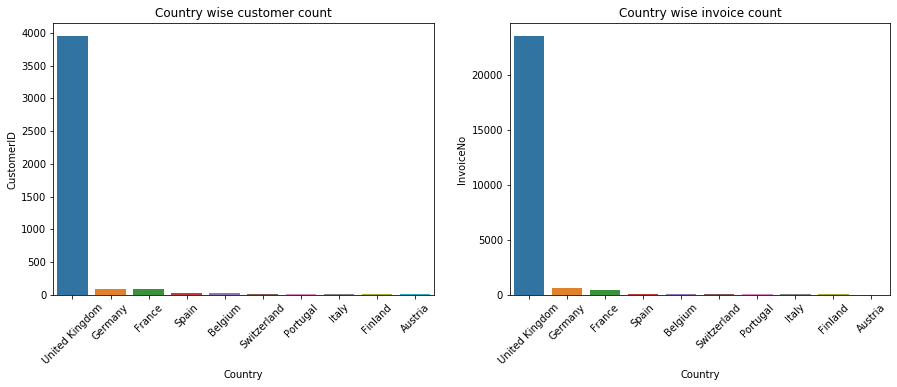

In [6]:
#Since customer behave differently in different geogrophical regions, let's look at the customer distribution
# or invoice distribution by country for top10 countries.

temp = data[['Country', 'CustomerID', 'InvoiceNo']].groupby(['Country']).agg({"CustomerID": "nunique", 
                                                                             "InvoiceNo": "nunique"}).reset_index().sort_values(by='CustomerID', ascending=False).head(10)
ax = plt.figure(figsize=(15, 5)).subplots(1,2)
ax=sns.barplot(x="Country", y="CustomerID", data=temp, ax=ax[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title("Country wise customer count")


ax=sns.barplot(x="Country", y="InvoiceNo", data=temp)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title("Country wise invoice count")
plt.show()

Most of the data is coming from "United Kingdom", therefore we'll be restricting our analysis to only this country

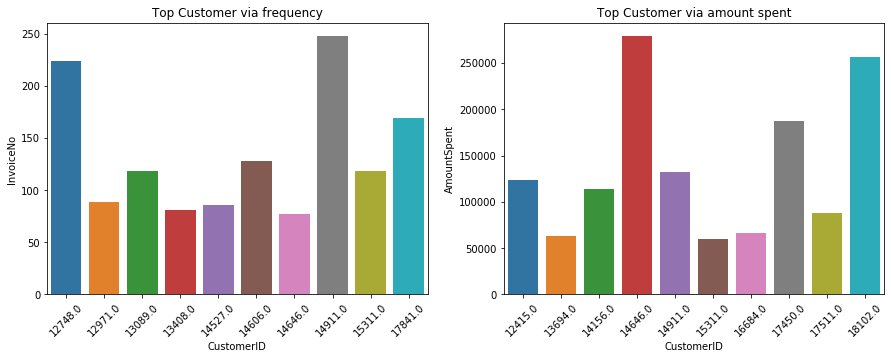

In [7]:
#Top Customers based on # of Invoices and Total $ spent

data['AmountSpent'] = data['Quantity'] * data['UnitPrice']
temp1 = data[['CustomerID', 'InvoiceNo', 'AmountSpent']].groupby(['CustomerID']).agg({"InvoiceNo": "nunique", 
                                                                             "AmountSpent": "sum"}).reset_index().sort_values(by=['InvoiceNo'], ascending=False).head(10)
temp2 = data[['CustomerID', 'InvoiceNo', 'AmountSpent']].groupby(['CustomerID']).agg({"InvoiceNo": "nunique", 
                                                                             "AmountSpent": "sum"}).reset_index().sort_values(by=['AmountSpent'], ascending=False).head(10)

ax = plt.figure(figsize=(15, 5)).subplots(1,2)
ax=sns.barplot(x="CustomerID", y="InvoiceNo", data=temp1, ax=ax[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title("Top Customer via frequency")


ax=sns.barplot(x="CustomerID", y="AmountSpent", data=temp2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title("Top Customer via amount spent")
plt.show()

Top customer based on frequency of visits is ID = 14911

Top customer based on $ amount spent is ID = 14646

Top customer based on dollar amount has less than half foorprint compared to the most frequent customer

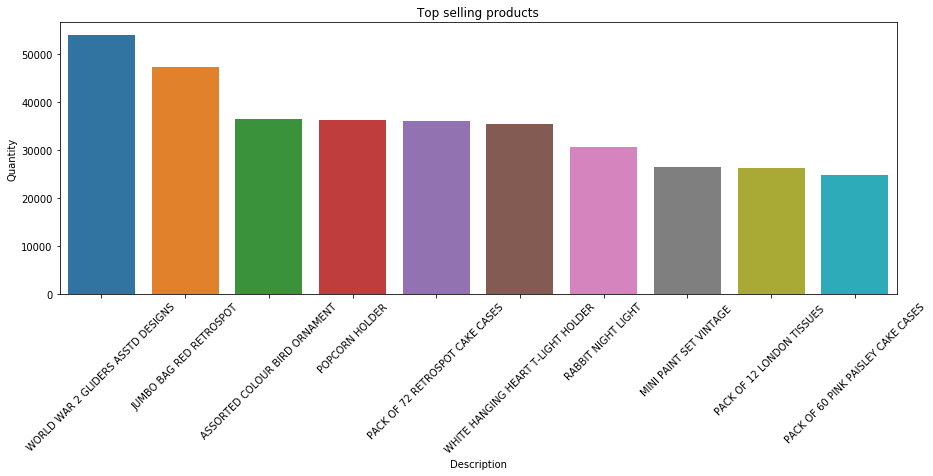

In [8]:
#Top 10 product sold

temp1 = data[['Description', 'Quantity']].groupby(['Description']).agg({"Quantity": "sum"}).reset_index().sort_values(by=['Quantity'], ascending=False).head(10)

ax = plt.figure(figsize=(15, 5))
ax=sns.barplot(x="Description", y="Quantity", data=temp1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title("Top selling products")
plt.show()

Top product is "World War 2 Gliders Asstd Designs" with over 50K units sold

# Data Cleaning...

To clean the dataset, we will follow some basic business logics:

1. Restrict the dataset to "UnitedKingdom"
2. Remove return orders
3. Remove rows where customerID are NA
4. Restrict the data to one year to better understand RFM

In [9]:
data_uk = data[data['Country'] == 'United Kingdom']
print('Shape of dataset after selecting country = United Kingdom ', data_uk.shape)

data_uk = data_uk[data_uk['Quantity'] > 0]
print('Shape of dataset after removing return orders ', data_uk.shape)

data_uk.dropna(subset=['CustomerID'],how='all',inplace=True, )
print('Shape of dataset after removing Null CustomerID ', data_uk.shape)


data_uk = data_uk[data_uk['InvoiceDate']>= "2010-12-09"]
print('Shape of dataset after removing more than 1 year worth of data ', data_uk.shape)

Shape of dataset after selecting country = United Kingdom  (495478, 9)
Shape of dataset after removing return orders  (486286, 9)
Shape of dataset after removing Null CustomerID  (354345, 9)
Shape of dataset after removing more than 1 year worth of data  (176137, 9)


In [10]:
#Summary of cleaned dataset

print("Shape of the dataset: ", data_uk.shape)
print("No. of invoices: ", data_uk['InvoiceNo'].nunique())
print("No. of Products: ", data_uk['Description'].nunique())
print("Min. & Max. Invoice date: ", min(data_uk['InvoiceDate']), ' & ', max(data_uk['InvoiceDate']))
print("Min. & Max. Qty: ", min(data_uk['Quantity']), ' & ', max(data_uk['Quantity']))
print("Min. & Max. Unit Price: ", min(data_uk['UnitPrice']), ' & ', max(data_uk['UnitPrice']))
print("No. of Customers: ", data_uk['CustomerID'].nunique())

Shape of the dataset:  (176137, 9)
No. of invoices:  8789
No. of Products:  3413
Min. & Max. Invoice date:  3/1/2011 10:08  &  9/9/2011 9:52
Min. & Max. Qty:  1  &  4300
Min. & Max. Unit Price:  0.0  &  8142.75
No. of Customers:  2864


# Making RFM dataframe

In [11]:
#To start with the RFM, we need to create, R(Recency) and F(Frequency) and M(Monetary) columns

In [12]:
#Recency Column

data_uk['Date'] = pd.DatetimeIndex(data_uk['InvoiceDate']).date


#We will make the last date as a reference
now = dt.date(2011,9,30)
print('Base or reference date: ', now)


#Calculate the last visit date
data_recency = data_uk.groupby(by='CustomerID', as_index=False)['Date'].max()
data_recency = data_recency.rename(columns={'CustomerID': 'CustomerID', 'Date': 'LastPurshaceDate'})
data_recency['Recency'] = data_recency['LastPurshaceDate'].apply(lambda x: (now - x).days)

#Drop LastPurchaseDate
data_recency.drop('LastPurshaceDate',axis=1,inplace=True)


data_recency.head()

Base or reference date:  2011-09-30


,CustomerID,Recency
0,12747.0,39
1,12748.0,0
2,12749.0,60
3,12820.0,4
4,12821.0,144


In [13]:
#Frequency Column

temp = data_uk
temp.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

#calculate frequency of purchases
data_freq = temp.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
data_freq = data_freq.rename(columns={'CustomerID': 'CustomerID', 'InvoiceNo': 'Frequency'})


data_freq.head()

,CustomerID,Frequency
0,12747.0,5
1,12748.0,96
2,12749.0,3
3,12820.0,1
4,12821.0,1


In [14]:
#Monetary Column

data_monetary = data_uk.groupby(by=['CustomerID'], as_index=False)['AmountSpent'].sum()
data_monetary = data_monetary.rename(columns={'CustomerID': 'CustomerID', 'AmountSpent': 'Monetary'})


data_monetary.head()

,CustomerID,Monetary
0,12747.0,191.85
1,12748.0,1054.43
2,12749.0,67.00
3,12820.0,15.00
4,12821.0,19.92


In [15]:
#Combining Recency, Frequency and Monetary dataframe


data_rfm = data_recency.merge(data_freq, how='left', on='CustomerID').merge(data_monetary, how='left', on='CustomerID')

In [16]:
data_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12747.0,39,5,191.85
1,12748.0,0,96,1054.43
2,12749.0,60,3,67.00
3,12820.0,4,1,15.00
4,12821.0,144,1,19.92


# RFM analysis using Quantiles

Here we will create customers segments from RFM Model using Quantiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [17]:
#Creating Quantiles dataframe for 25%, 50%, 75% to create 4 buckets

quantiles = data_rfm.drop('CustomerID', axis=1).quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,15.0,1.0,16.35
0.50,49.0,2.0,35.40
0.75,113.0,3.0,92.42


In [18]:
#Function to create segments of Recency

def RScore(x, p, quantiles):
    #return quantiles[quantiles.index == 0.25][p]
    if x <= int(quantiles[quantiles.index == 0.25][p]):
        return 4
    elif x <= int(quantiles[quantiles.index == 0.50][p]):
        return 3
    elif x <= int(quantiles[quantiles.index == 0.75][p]): 
        return 2
    else:
        return 1

    
#Function to create segments of Frequency and Monetary
def FMScore(x, p, quantiles):
    if float(x) <= float(quantiles[quantiles.index == 0.25][p]):
        return 1
    elif float(x) <= float(quantiles[quantiles.index == 0.50][p]):
        return 2
    elif float(x) <= float(quantiles[quantiles.index == 0.75][p]): 
        return 3
    else:
        return 4

In [19]:
#Calculating each customer's R/F/M quartiles based on quantiles table and functions defined above

rfm_segment = data_rfm

rfm_segment['R_Quartile'] = rfm_segment['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segment['F_Quartile'] = rfm_segment['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segment['M_Quartile'] = rfm_segment['Monetary'].apply(FMScore, args=('Monetary',quantiles,))



rfm_segment['RFMScore'] = rfm_segment.R_Quartile.map(str) +rfm_segment.F_Quartile.map(str) +rfm_segment.M_Quartile.map(str)
rfm_segment.head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12747.0,39,5,191.85,3,4,4,344
1,12748.0,0,96,1054.43,4,4,4,444
2,12749.0,60,3,67.00,2,3,3,233
3,12820.0,4,1,15.00,4,1,1,411
4,12821.0,144,1,19.92,1,1,2,112


We can define various customer segments based on our RFM segment:

1.Core - Best Customers
 
 RFM Score: 444
 
 Who They Are: Highly engaged customers who visited recently, the most often visited and generates the most revenue.


2.Loyal - Most Loyal Customers
 
 RFM Score: X4X
 
 Who They Are: Customers who are most frequent
 
 
3.BigSpenders - Highest Paying Customers
 
 RFM Score: XX4
 
 Who They Are: Customers who have generated the most revenue
 
 
4.Rookies - Your Newest Customers
 
 RFM Score: 41X
 
 Who They Are: First time buyers


5.LoosingBigSpenders - Focust point!! where good customers are slipping

RFM Score: 244 and 234

Who They Are: Customers who were frequent and big spenders but have not visited the store in a while


6.LostBigSpenders - Good customers who are lost

RFM Score: 144 and 134

Who They Are: Customers who were frequent and big spenders but have not visited the store from a long time


7.LostCheapSpenders - Bad/Cheap customers who are lost

RFM Score: 141 and 131

Who They Are: Customers who were frequent and big spenders but have not visited the store from a long time


8.Regular - The customers having common behaviour across these metrics

RFM Score: Remaining Scores

Who They Are: Customer who have average metrics across each RFM scores

In [20]:
#Snapshot of some of the KPI’s against each customer segment

KPI = pd.DataFrame(columns=['Segment', 'CustomerCount', 'RecencyMean', 'FrequencyMean', 
                            'MonetaryMean', '%Customer', '%Sales'])
KPI['Segment'] = ['Core', 'Loyal', 'BigSpenders', 'Rookies', 'LoosingBigSpenders', 'LostBigSpenders', 'LostCheapSpenders']


In [21]:
# segment_dict = {'Core':[(4, 4, 4)], 
#                 'Loyal':[('X', 4, 'X')], 
#                 'BigSpenders':[('X', 'X', 4)], 
#                 'Rookies':[(4, 1, 'X')], 
#                 'LoosingBigSpenders':[(2, 4, 4), (2, 3, 4)], 
#                 'LostBigSpenders':[(1, 4, 4), (1, 3, 4)], 
#                 'LostCheapSpenders':[(1,4, 1), (1, 3, 1)]}

In [22]:
#Segment == Core (444)

CustomerCount = rfm_segment[rfm_segment.RFMScore == '444']['CustomerID'].count()
RecencyMean = round(rfm_segment[rfm_segment.RFMScore == '444']['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[rfm_segment.RFMScore == '444']['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[rfm_segment.RFMScore == '444']['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[rfm_segment.RFMScore == '444']['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[rfm_segment.RFMScore == '444']['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[0].CustomerCount = CustomerCount
KPI.loc[0].RecencyMean = RecencyMean
KPI.loc[0].FrequencyMean = FrequencyMean
KPI.loc[0].MonetaryMean = MonetaryMean
KPI.loc[0]['%Customer'] = PerCustomer
KPI.loc[0]['%Sales'] = PerSales

In [23]:
# Segment == Loyal (X4X)

CustomerCount = rfm_segment[rfm_segment.F_Quartile == 4]['CustomerID'].count()
RecencyMean = round(rfm_segment[rfm_segment.F_Quartile == 4]['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[rfm_segment.F_Quartile == 4]['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[rfm_segment.F_Quartile == 4]['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[rfm_segment.F_Quartile == 4]['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[rfm_segment.F_Quartile == 4]['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[1].CustomerCount = CustomerCount
KPI.loc[1].RecencyMean = RecencyMean
KPI.loc[1].FrequencyMean = FrequencyMean
KPI.loc[1].MonetaryMean = MonetaryMean
KPI.loc[1]['%Customer'] = PerCustomer
KPI.loc[1]['%Sales'] = PerSales

In [24]:
# Segment == BigSpenders (XX4)

CustomerCount = rfm_segment[rfm_segment.M_Quartile == 4]['CustomerID'].count()
RecencyMean = round(rfm_segment[rfm_segment.M_Quartile == 4]['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[rfm_segment.M_Quartile == 4]['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[rfm_segment.M_Quartile == 4]['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[rfm_segment.M_Quartile == 4]['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[rfm_segment.M_Quartile == 4]['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[2].CustomerCount = CustomerCount
KPI.loc[2].RecencyMean = RecencyMean
KPI.loc[2].FrequencyMean = FrequencyMean
KPI.loc[2].MonetaryMean = MonetaryMean
KPI.loc[2]['%Customer'] = PerCustomer
KPI.loc[2]['%Sales'] = PerSales

In [25]:
# Segment == Rookies (41X)

CustomerCount = rfm_segment[(rfm_segment.R_Quartile == 4) & (rfm_segment.F_Quartile == 1)]['CustomerID'].count()
RecencyMean = round(rfm_segment[(rfm_segment.R_Quartile == 4) & (rfm_segment.F_Quartile == 1)]['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[(rfm_segment.R_Quartile == 4) & (rfm_segment.F_Quartile == 1)]['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[(rfm_segment.R_Quartile == 4) & (rfm_segment.F_Quartile == 1)]['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[(rfm_segment.R_Quartile == 4) & (rfm_segment.F_Quartile == 1)]['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[(rfm_segment.R_Quartile == 4) & (rfm_segment.F_Quartile == 1)]['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[3].CustomerCount = CustomerCount
KPI.loc[3].RecencyMean = RecencyMean
KPI.loc[3].FrequencyMean = FrequencyMean
KPI.loc[3].MonetaryMean = MonetaryMean
KPI.loc[3]['%Customer'] = PerCustomer
KPI.loc[3]['%Sales'] = PerSales

In [26]:
# Segment == LoosingBigSpenders (244, 234)

CustomerCount = rfm_segment[rfm_segment.RFMScore.isin(['244', '234'])]['CustomerID'].count()
RecencyMean = round(rfm_segment[rfm_segment.RFMScore.isin(['244', '234'])]['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[rfm_segment.RFMScore.isin(['244', '234'])]['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[rfm_segment.RFMScore.isin(['244', '234'])]['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[rfm_segment.RFMScore.isin(['244', '234'])]['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[rfm_segment.RFMScore.isin(['244', '234'])]['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[4].CustomerCount = CustomerCount
KPI.loc[4].RecencyMean = RecencyMean
KPI.loc[4].FrequencyMean = FrequencyMean
KPI.loc[4].MonetaryMean = MonetaryMean
KPI.loc[4]['%Customer'] = PerCustomer
KPI.loc[4]['%Sales'] = PerSales

In [27]:
# Segment == LostBigSpenders (144, 134)

CustomerCount = rfm_segment[rfm_segment.RFMScore.isin(['144', '134'])]['CustomerID'].count()
RecencyMean = round(rfm_segment[rfm_segment.RFMScore.isin(['144', '134'])]['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[rfm_segment.RFMScore.isin(['144', '134'])]['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[rfm_segment.RFMScore.isin(['144', '134'])]['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[rfm_segment.RFMScore.isin(['144', '134'])]['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[rfm_segment.RFMScore.isin(['144', '134'])]['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[5].CustomerCount = CustomerCount
KPI.loc[5].RecencyMean = RecencyMean
KPI.loc[5].FrequencyMean = FrequencyMean
KPI.loc[5].MonetaryMean = MonetaryMean
KPI.loc[5]['%Customer'] = PerCustomer
KPI.loc[5]['%Sales'] = PerSales

In [28]:
# Segment == LostCheapSpenders (141, 131)

CustomerCount = rfm_segment[rfm_segment.RFMScore.isin(['141', '131'])]['CustomerID'].count()
RecencyMean = round(rfm_segment[rfm_segment.RFMScore.isin(['141', '131'])]['Recency'].mean(), 2)
FrequencyMean = round(rfm_segment[rfm_segment.RFMScore.isin(['141', '131'])]['Frequency'].mean(), 2)
MonetaryMean = round(rfm_segment[rfm_segment.RFMScore.isin(['141', '131'])]['Monetary'].mean(), 2)
PerCustomer = round((rfm_segment[rfm_segment.RFMScore.isin(['141', '131'])]['CustomerID'].count() /\
                     rfm_segment['CustomerID'].count())*100, 2)
PerSales = round((rfm_segment[rfm_segment.RFMScore.isin(['141', '131'])]['Monetary'].sum() /\
                     rfm_segment['Monetary'].sum())*100, 2)


KPI.loc[6].CustomerCount = CustomerCount
KPI.loc[6].RecencyMean = RecencyMean
KPI.loc[6].FrequencyMean = FrequencyMean
KPI.loc[6].MonetaryMean = MonetaryMean
KPI.loc[6]['%Customer'] = PerCustomer
KPI.loc[6]['%Sales'] = PerSales

In [29]:
KPI

,Segment,CustomerCount,RecencyMean,FrequencyMean,MonetaryMean,%Customer,%Sales
0,Core,218,6.16,11.85,967.86,7.61,42.38
1,Loyal,687,25.87,7.77,483.8,23.99,66.76
2,BigSpenders,716,38.92,6.59,604.12,25,86.89
3,Rookies,201,6.86,1,38.36,7.02,1.55
4,LoosingBigSpenders,76,72.21,4.75,917.97,2.65,14.01
5,LostBigSpenders,12,136.33,3.92,190.88,0.42,0.46
6,LostCheapSpenders,2,122,3,10.8,0.07,0


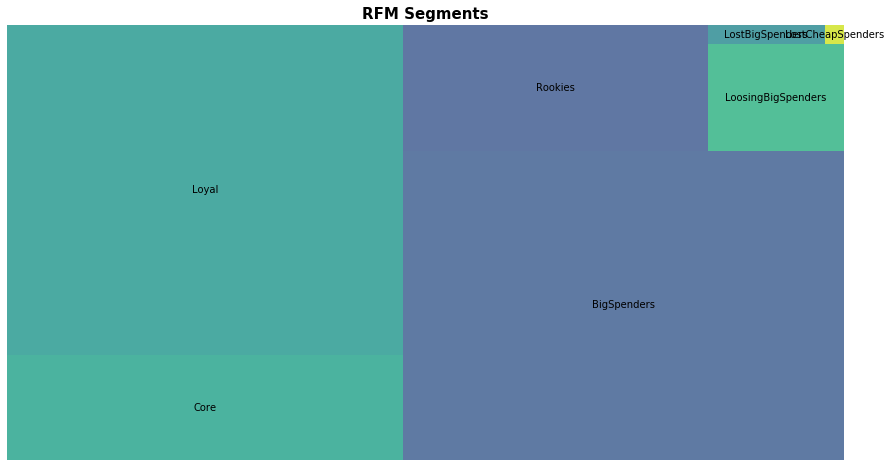

In [30]:
#Visualizing the RFM segments

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 8)
squarify.plot(sizes=KPI['CustomerCount'], 
              label=['Core',
                     'Loyal',
                     'BigSpenders',
                     'Rookies',
                     'LoosingBigSpenders', 
                     'LostBigSpenders',
                     'LostCheapSpenders'], alpha=0.8, )
plt.title("RFM Segments",fontsize=15,fontweight="bold")
plt.axis('off')
plt.show()

# Customer Segmentaton using K-Means

We will create customer segment using K-Means algorithm on the R, F, M dataset (data_rfm) created above. 

In [43]:
data_kmeans = data_rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

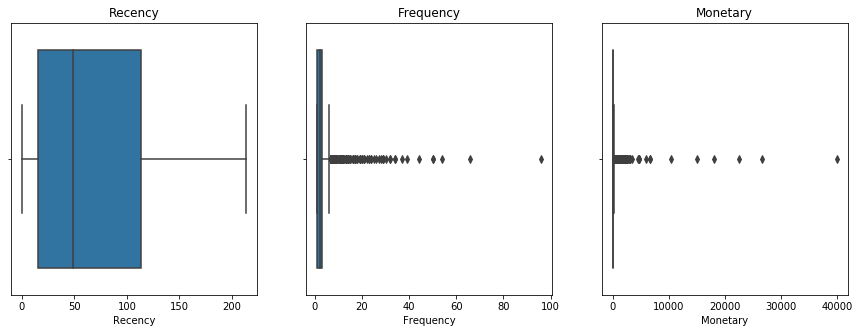

In [44]:
#As K-Means algorithm is sensitive to outliers, we will first check for any outliers in R, F, M using boxplot


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

ax=sns.boxplot(x=data_kmeans['Recency'], ax=ax1)
ax.set_title("Recency")


ax=sns.boxplot(x=data_kmeans['Frequency'], ax=ax2)
ax.set_title("Frequency")

ax=sns.boxplot(x=data_kmeans['Monetary'], ax=ax3)
ax.set_title("Monetary")

plt.show()

In [46]:
data_kmeans.shape

(2864, 4)

In [49]:
#Removing outliers using quantiles, i.e. datapoints residing outside 99 percentile within R, F and M


#Creating Individual tables after removing top 1% of outliers

recency_cleaned = data_kmeans[data_kmeans['Recency']<data_kmeans['Recency'].quantile(0.99)][['CustomerID', 'Recency']]
frequency_cleaned = data_kmeans[data_kmeans['Frequency']<data_kmeans['Recency'].quantile(0.99)][['CustomerID', 'Frequency']]
monetary_cleaned = data_kmeans[data_kmeans['Monetary']<data_kmeans['Recency'].quantile(0.99)][['CustomerID', 'Monetary']]


#Combining cleaned dataframe into one

data_kmeans = recency_cleaned.merge(frequency_cleaned, how='inner', on='CustomerID').merge(monetary_cleaned, 
                                                                                         how='inner', on='CustomerID')


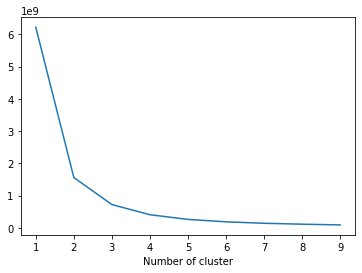

In [54]:
#Finding Optimum Clusters using Elbow curve usnig K-Means

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_kmeans)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

we can see using above elbow curve, 3 as optimum no of clusters which means there will be three segments for recency, 
frequency, and monetary

In [65]:
#Applying K-Means with K==3

#Recency Clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_kmeans[['Recency']])
data_kmeans['RecencyCluster']=kmeans.predict(data_kmeans[['Recency']])

#Frequency Clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_kmeans[['Frequency']])
data_kmeans['FrequencyCluster']=kmeans.predict(data_kmeans[['Frequency']])


#Monetary Clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_kmeans[['Monetary']])
data_kmeans['MonetaryCluster']=kmeans.predict(data_kmeans[['Monetary']])

In [66]:
#Since clusters formed are not ordered clusters i.e. mean of cluster 1 > mean of cluster 2 as K-Means randomly assign
#clusters. Reordering the clusters.

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


data_kmeans = order_cluster('RecencyCluster','Recency', data_kmeans, False)
data_kmeans = order_cluster('FrequencyCluster','Frequency', data_kmeans, True)
data_kmeans = order_cluster('MonetaryCluster','Monetary', data_kmeans, True)

In [68]:
#Creating individual cluster tags for each of the R, F and M

# Define a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 


# Creating Recency Custer Tag Column
c=data_kmeans.groupby('RecencyCluster')['Recency'].agg(['min','max','mean']).reset_index()
r1='<='+str(c.iloc[2,2]) 
r2=str(c.iloc[1,1])+' to '+str(c.iloc[1,2]) 
r3='>='+str(c.iloc[0,1])
# Create the dictionary 
R ={0 : r3, 1 : r2, 2 : r1} 
data_kmeans['RecencyClusterTag']=data_kmeans['RecencyCluster'].apply(set_value, args =(R, )) 

# Creating Frequency Custer Tag Column
a=data_kmeans.groupby('FrequencyCluster')['Frequency'].agg(['min','max','mean']).reset_index()
f1='<='+str(a.iloc[0,2]) 
f2=str(a.iloc[1,1])+' to '+str(a.iloc[1,2]) 
f3='>='+str(a.iloc[2,1])
# Create the dictionary 
F ={0 : f1, 1 : f2, 2 :f3} 
data_kmeans['FrequencyClusterTag']=data_kmeans['FrequencyCluster'].apply(set_value, args =(F, )) 

# Creating Monetary Custer Tag Column
b=data_kmeans.groupby('MonetaryCluster')['Monetary'].agg(['min','max','mean']).reset_index()
m1='<='+str(int(round(b.iloc[0,2]))) 
m2=str(int(round(b.iloc[0,2])+1))+' to '+str(int(round(b.iloc[1,2]))) 
m3='>='+str(int(round(b.iloc[1,2])+1))
# Create the dictionary 
M ={0 : m1, 1 : m2, 2 :m3} 
data_kmeans['MonetaryClusterTag']=data_kmeans['MonetaryCluster'].apply(set_value, args =(M, )) 

data_kmeans["FrequencyClusterTag"] = data_kmeans["FrequencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[f1, f2, f3]))
data_kmeans["MonetaryClusterTag"] = data_kmeans["MonetaryClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[m1, m2,m3]))
data_kmeans["RecencyClusterTag"] = data_kmeans["RecencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3]))


In [70]:
data_kmeans.head()

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,RecencyClusterTag,FrequencyClusterTag,MonetaryClusterTag
0,12747.0,39,5,191.85,2,1,2,<=52,3 to 5,>=124
1,12919.0,46,3,167.80,2,1,2,<=52,3 to 5,>=124
2,12924.0,18,3,162.67,2,1,2,<=52,3 to 5,>=124
3,12948.0,35,4,131.30,2,1,2,<=52,3 to 5,>=124
4,13026.0,22,3,194.16,2,1,2,<=52,3 to 5,>=124


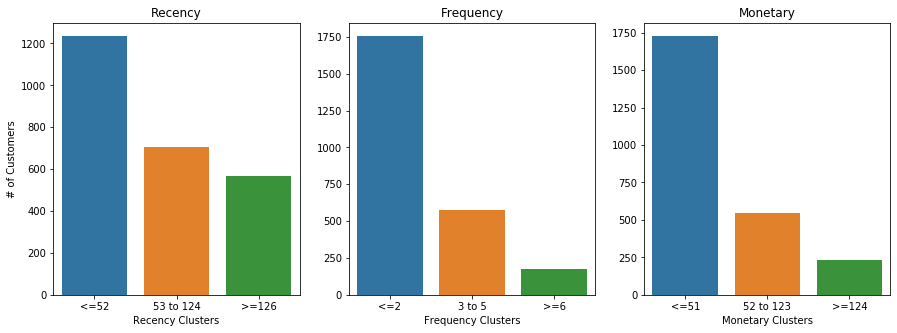

In [76]:
#Visualizing the clusters
#Customer distribution in each clusters

temp1 = data_kmeans.groupby('RecencyClusterTag').agg({'CustomerID':'count'}).reset_index()
temp2= data_kmeans.groupby('FrequencyClusterTag').agg({'CustomerID':'count'}).reset_index()
temp3 = data_kmeans.groupby('MonetaryClusterTag').agg({'CustomerID':'count'}).reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

ax=sns.barplot(x='RecencyClusterTag', y='CustomerID', data=temp1 , ax=ax1)
ax.set(xlabel="Recency Clusters", ylabel = "# of Customers")
ax.set_title("Recency")


ax=sns.barplot(x='FrequencyClusterTag', y='CustomerID', data=temp2 , ax=ax2)
ax.set(xlabel="Frequency Clusters", ylabel = "")
ax.set_title("Frequency")


ax=sns.barplot(x='MonetaryClusterTag', y='CustomerID', data=temp3 , ax=ax3)
ax.set(xlabel="Monetary Clusters", ylabel = "")
ax.set_title("Monetary")

plt.show()

We can define various customer segments as we did before based on the clusters:

1.Core - Best Customers

RFM clusters: >=126, >=6, >=124

Who They Are: Highly engaged customers who visited recently, the most often visited and generates the most revenue.

2.Loyal - Most Loyal Customers

Frequency cluster: >=6

Who They Are: Customers who are most frequent

3.BigSpenders - Highest Paying Customers

Monetary clusters: >=124

Who They Are: Customers who have generated the most revenue